In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import torch.nn.functional as F

pd.set_option('display.max_columns', None)

In [2]:
supervector_df_Standard = pd.read_csv(r'D:\Mémoire\Mémoire\Projet\ellipsometry\results\20250511_2019\supervector_maxwell_garnett.csv')
print("Supervector DataFrame :")
supervector_df_Standard.head()

Supervector DataFrame :


,psi,delta,wavelength,thickness,vfraction
0,26.676930,20.987621,361.5,0.0,0.001
1,25.343687,11.741441,372.8,0.0,0.001
2,23.277088,7.743301,381.3,0.0,0.001
3,21.324359,5.802981,391.0,0.0,0.001
4,19.850838,4.841817,400.8,0.0,0.001


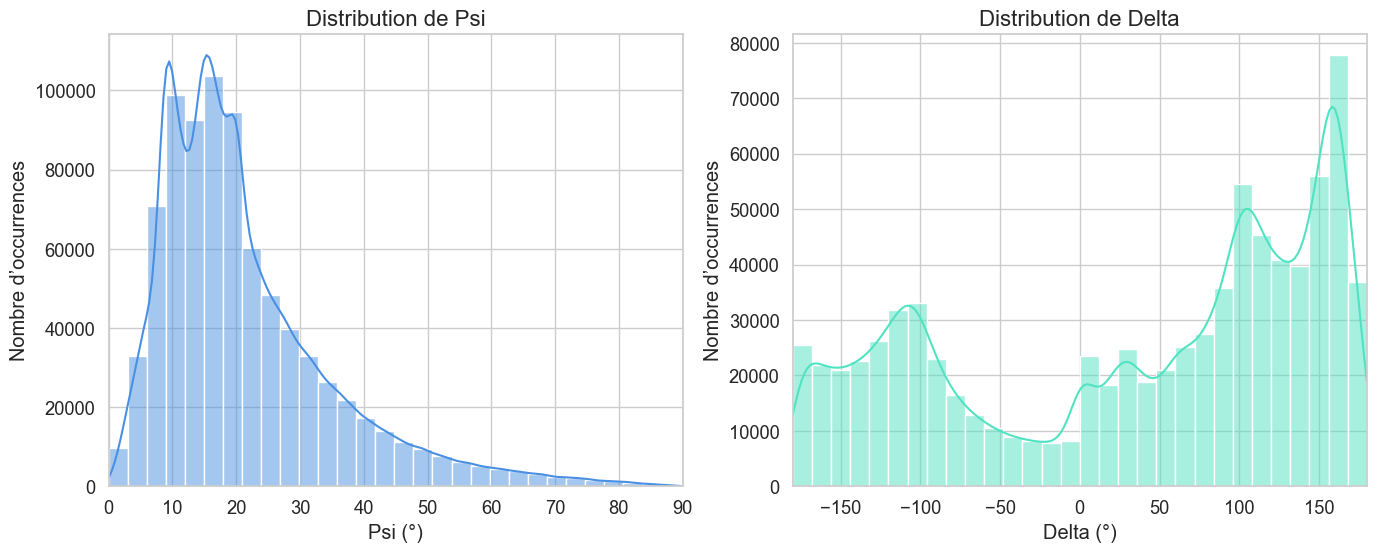

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set(style="whitegrid", font_scale=1.2)
plt.rcParams["font.family"] = "sans-serif"

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.histplot(supervector_df_Standard["psi"], bins=30, kde=True, ax=axes[0], color="#4A90E2")
axes[0].set_title("Distribution de Psi", fontsize=16)
axes[0].set_xlabel("Psi (°)")
axes[0].set_ylabel("Nombre d’occurrences")
axes[0].set_xlim(0, 90)

sns.histplot(supervector_df_Standard["delta"], bins=30, kde=True, ax=axes[1], color="#50E3C2")
axes[1].set_title("Distribution de Delta", fontsize=16)
axes[1].set_xlabel("Delta (°)")
axes[1].set_ylabel("Nombre d’occurrences")
axes[1].set_xlim(-180, 180)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


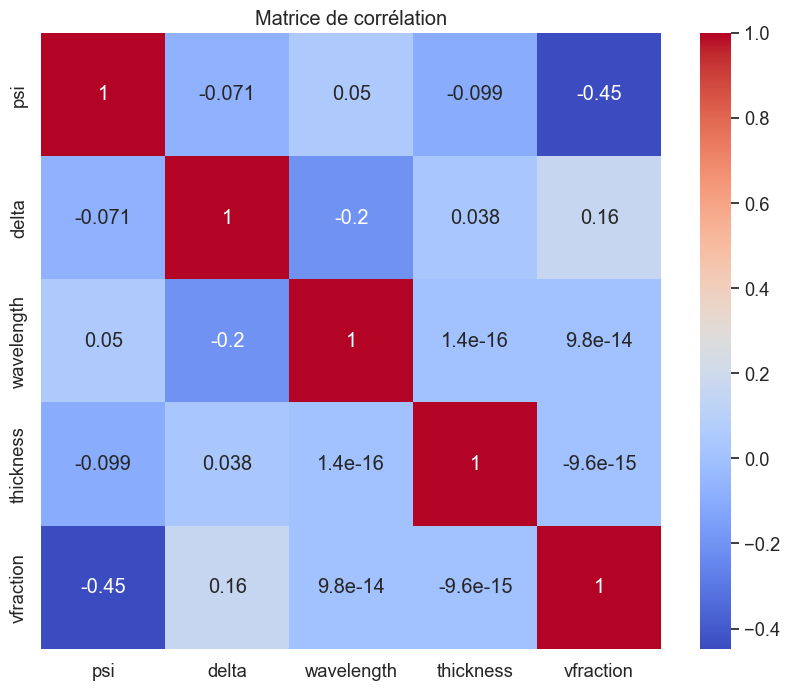

In [ ]:
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(supervector_df_Standard.corr(), annot=True, cmap='coolwarm')
plt.title("Matrice de corrélation")
plt.show()

In [ ]:
def group_and_flatten(df):
    possible_group_cols = ['thickness', 'vfraction', 'lambda0', 'gamma', 'amplitude']
    
    group_cols = [col for col in possible_group_cols if col in df.columns]
    
    if not group_cols:
        raise ValueError("Aucune colonne de groupement appropriée trouvée dans le dataframe")
    
    grouped = df.groupby(group_cols)[['psi', 'delta']].apply(
        lambda x: x.values.flatten()
    ).reset_index()
    
    grouped.columns = list(group_cols) + ['psi_delta_flatten']
    
    return grouped

grouped_standard = group_and_flatten(supervector_df_Standard)
grouped_standard.head()


,thickness,vfraction,psi_delta_flatten
0,0.0,0.001,"[26.67693014168062, 20.987620827640164, 25.343..."
1,0.0,0.002,"[26.67693014168064, 20.987620827640164, 25.343..."
2,0.0,0.003,"[26.67693014168062, 20.98762082764017, 25.3436..."
3,0.0,0.004,"[26.67693014168064, 20.98762082764015, 25.3436..."
4,0.0,0.005,"[26.67693014168064, 20.987620827640143, 25.343..."


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

def prepare_and_split_data(grouped_df, test_size=0.2, random_state=42):
    """
    Prepare features and targets from the dataframe and split into train and test sets,
    preserving the relationship between target variables.

    Args:
    -----
    grouped_df : pandas.DataFrame
        DataFrame containing a column 'psi_delta_flatten' for features and other columns for targets.

    test_size : float, optional
        Proportion of the dataset to include in the test split (default is 0.2).

    random_state : int, optional
        Random seed for reproducibility (default is 42).

    Returns:
    --------
    X_train : numpy.ndarray
        Training features.

    X_test : numpy.ndarray
        Testing features.

    y_train : numpy.ndarray
        Training targets (all target variables preserved).

    y_test : numpy.ndarray
        Testing targets.

    label_names : list of str
        List of target variable names.
    """

    # Extract features and target arrays
    X = np.stack(grouped_df['psi_delta_flatten'].values)
    y = grouped_df.drop(columns=['psi_delta_flatten']).values
    label_names = grouped_df.drop(columns=['psi_delta_flatten']).columns.tolist()

    # Split dataset into train and test subsets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # Print shapes for verification
    print(f"X_train shape: {X_train.shape}")
    print(f"X_test shape: {X_test.shape}")
    print(f"y_train shape: {y_train.shape} (labels: {label_names})")
    print(f"y_test shape: {y_test.shape}")

    return X_train, X_test, y_train, y_test, label_names


In [ ]:
X_train_std, X_test_std, y_train_std, y_test_std, labels_std = prepare_and_split_data(grouped_standard)

X_train shape: (14640, 90)
X_test shape: (3660, 90)
y_train shape: (14640, 2) (labels: ['thickness', 'vfraction'])
y_test shape: (3660, 2)


In [ ]:
import numpy as np

def augment_data(X, y, noise_level=0.01, num_augmentations=3):
    """
    Augment data by adding Gaussian noise to features and labels.

    Args:
    -----
    X : numpy.ndarray
        Feature array (e.g., psi_delta_flatten).

    y : numpy.ndarray
        Label array (physical parameters).

    noise_level : float, optional
        Relative noise level as standard deviation multiplier (default is 0.01).

    num_augmentations : int, optional
        Number of augmented copies to generate (default is 3).

    Returns:
    --------
    X_augmented : numpy.ndarray
        Original and augmented feature data concatenated.

    y_augmented : numpy.ndarray
        Original and augmented label data concatenated.
    """

    # Initialize lists with original data
    X_augmented = [X]
    y_augmented = [y]

    # Generate augmented copies by adding Gaussian noise
    for _ in range(num_augmentations):
        noise_X = np.random.normal(0, noise_level * np.std(X, axis=0), X.shape)
        noise_y = np.random.normal(0, noise_level * np.std(y, axis=0), y.shape)

        X_augmented.append(X + noise_X)
        y_augmented.append(y + noise_y)

    # Concatenate original and augmented data
    return np.concatenate(X_augmented), np.concatenate(y_augmented)


In [ ]:
X_train_augmented, y_train_augmented = augment_data(X_train_std, y_train_std, noise_level=0.01, num_augmentations=3)

print(f"X_train original shape: {X_train_std.shape}")
print(f"X_train augmented shape: {X_train_augmented.shape}")
print(f"y_train original shape: {y_train_std.shape}")
print(f"y_train augmented shape: {y_train_augmented.shape}")

X_train original shape: (14640, 90)
X_train augmented shape: (58560, 90)
y_train original shape: (14640, 2)
y_train augmented shape: (58560, 2)


In [ ]:
from sklearn.preprocessing import MinMaxScaler
import torch
import numpy as np

def preprocess_and_convert(X_train, X_test, y_train, y_test):
    """
    Apply MinMax scaling to features and labels, then convert to PyTorch tensors.

    Args:
    -----
    X_train, X_test : array-like
        Training and test feature data.

    y_train, y_test : array-like
        Training and test label data.

    Returns:
    --------
    dict
        Dictionary containing scaled PyTorch tensors for train/test features and labels,
        and the fitted MinMax scalers for X and y.
    """
    # Scale features with MinMaxScaler
    scaler_X = MinMaxScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)

    # Scale labels with MinMaxScaler
    scaler_y = MinMaxScaler()
    y_train_scaled = scaler_y.fit_transform(y_train)
    y_test_scaled = scaler_y.transform(y_test)

    # Convert scaled data to PyTorch tensors
    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)

    return {
        'X_train': X_train_tensor,
        'X_test': X_test_tensor,
        'y_train': y_train_tensor,
        'y_test': y_test_tensor,
        'scaler_X': scaler_X,
        'scaler_y': scaler_y
    }


def inverse_transform_y(y_pred_tensor, scaler_y):
    """
    Reverse MinMax scaling on predicted labels.

    Args:
    -----
    y_pred_tensor : torch.Tensor
        Tensor containing predicted labels.

    scaler_y : sklearn.preprocessing.MinMaxScaler or None
        Fitted MinMaxScaler for labels. If None, returns numpy array without scaling.

    Returns:
    --------
    numpy.ndarray
        Predicted labels transformed back to original scale.
    """
    if scaler_y is None:
        return y_pred_tensor.numpy()

    y_pred_np = y_pred_tensor.detach().numpy()
    return scaler_y.inverse_transform(y_pred_np)


In [ ]:
data = preprocess_and_convert(X_train_std, X_test_std, y_train_std, y_test_std)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FlexibleNN(nn.Module):
    """
    Flexible feedforward neural network.

    Features:
    - Configurable number of hidden layers and sizes
    - Choice of activation functions
    - Custom weight initialization
    - Optional dropout
    - Optional element-wise sigmoid or ReLU on specific output indices

    Args:
    -----
    input_dim : int
        Number of input features.
    output_dim : int
        Number of output neurons.
    hidden_dims : list of int, optional
        List of hidden layer sizes (default: [256, 256, 256]).
    activation : str, optional
        Activation function for hidden layers ('relu', 'leaky_relu', 'elu', 'tanh', 'sigmoid').
        Default is 'leaky_relu'.
    dropout_rate : float, optional
        Dropout probability (default: 0.0, i.e., no dropout).
    apply_sigmoid_to : list of int or None, optional
        Indices of output neurons to apply sigmoid activation to (default: None).
    apply_relu_to : list of int or None, optional
        Indices of output neurons to apply ReLU activation to (default: None).

    Methods:
    --------
    forward(x) : Tensor
        Forward pass through the network.
    """
    def __init__(self, input_dim, output_dim, 
                 hidden_dims=[256, 256, 256],
                 activation='leaky_relu',
                 dropout_rate=0.0,
                 apply_sigmoid_to=None,
                 apply_relu_to=None):
        super(FlexibleNN, self).__init__()

        # Store output activation settings
        self.apply_sigmoid_to = apply_sigmoid_to
        self.apply_relu_to = apply_relu_to

        # Build hidden layers
        layers = []
        dims = [input_dim] + hidden_dims
        for i in range(len(dims) - 1):
            layers.append(nn.Linear(dims[i], dims[i + 1]))
            layers.append(self._get_activation(activation))
            if dropout_rate > 0:
                layers.append(nn.Dropout(dropout_rate))

        self.hidden_layers = nn.Sequential(*layers)
        self.output = nn.Linear(dims[-1], output_dim)

        # Initialize weights
        self._init_weights()

    def _init_weights(self):
        """Initialize weights using Kaiming uniform for linear layers."""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
                nn.init.constant_(m.bias, 0.1)

    def _get_activation(self, name):
        """Return the activation function by name."""
        return {
            'relu': nn.ReLU(),
            'leaky_relu': nn.LeakyReLU(0.1),
            'elu': nn.ELU(),
            'tanh': nn.Tanh(),
            'sigmoid': nn.Sigmoid(),
        }.get(name.lower(), nn.LeakyReLU(0.1))

    def forward(self, x):
        """Perform forward pass."""
        x = self.hidden_layers(x)
        x = self.output(x)

        # Apply sigmoid to selected output indices if specified
        if self.apply_sigmoid_to is not None:
            x = x.clone()
            for idx in self.apply_sigmoid_to:
                x[:, idx] = torch.sigmoid(x[:, idx])

        # Apply ReLU to selected output indices if specified
        if self.apply_relu_to is not None:
            x = x.clone()
            for idx in self.apply_relu_to:
                x[:, idx] = F.relu(x[:, idx])

        return x


In [ ]:
def plot_losses(train_loss, test_loss, title):
    plt.style.use('default')
    plt.figure(figsize=(14, 7))

    plt.plot(train_loss, label='Perte Entraînement', color='navy', linewidth=2.5)
    plt.plot(test_loss, label='Perte Test', color='darkorange', linewidth=2.5)

    min_test_loss = min(test_loss)
    min_epoch = test_loss.index(min_test_loss)
    plt.scatter(min_epoch, min_test_loss, color='crimson', s=50, zorder=5,
                label=f'Min Test Loss\n(Epoch {min_epoch}): {min_test_loss:.4f}')

    plt.xlabel('Épochs', fontsize=18)
    plt.ylabel('Loss', fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    n_epochs = max(len(train_loss), len(test_loss))
    plt.xlim(0, n_epochs - 1)
    plt.legend(fontsize=14, loc='best')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

def plot_predictions(model, X_test, y_test, scaler_y, label_names, title):
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test)

    if y_pred.shape[1] != y_test.shape[1]:
        print(f"Erreur : dimensions incohérentes ({y_pred.shape[1]} vs {y_test.shape[1]})")
        return

    y_test_orig = inverse_transform_y(y_test, scaler_y)
    y_pred_orig = inverse_transform_y(y_pred, scaler_y)

    n_params = y_test.shape[1]
    plt.style.use('default')
    plt.figure(figsize=(8 * n_params, 6))

    for i in range(n_params):
        plt.subplot(1, n_params, i + 1)

        x = y_test_orig[:, i]
        y = y_pred_orig[:, i]

        min_val = min(x.min(), y.min())
        max_val = max(x.max(), y.max())
        margin = 0.05 * (max_val - min_val)
        lim_min = min_val - margin
        lim_max = max_val + margin

        plt.scatter(x, y, alpha=0.6, color='dodgerblue', edgecolor='k', s=20)
        plt.plot([lim_min, lim_max], [lim_min, lim_max], 'r--', linewidth=2)

        plt.xlabel('Valeur réelle', fontsize=16)
        plt.ylabel('Valeur prédite', fontsize=16)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.xlim(0, lim_max)
        plt.ylim(0, lim_max)
        plt.title(f"Prédiction pour {label_names[i]}", fontsize=16)

    plt.tight_layout()
    plt.show()

In [ ]:
import time

def train_model(model, data, epochs=1000, learning_rate=0.0005, 
                criterion=nn.MSELoss(), patience=20):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    train_losses = []
    test_losses = []
    best_loss = float('inf')
    patience_counter = 0

    X_train, X_test = data['X_train'], data['X_test']
    y_train, y_test = data['y_train'], data['y_test']

    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        y_pred_train = model(X_train)
        loss_train = criterion(y_pred_train, y_train)
        loss_train.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            y_pred_test = model(X_test)
            loss_test = criterion(y_pred_test, y_test)

        train_losses.append(loss_train.item())
        test_losses.append(loss_test.item())

        if loss_test.item() < best_loss:
            best_loss = loss_test.item()
            best_model_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch + 1}")
            break

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {loss_train.item():.4f}, Test Loss: {loss_test.item():.4f}")

    end_time = time.time()
    total_time = end_time - start_time
    print(f"Temps total d'entraînement : {total_time:.2f} secondes")
    model.load_state_dict(best_model_state)
    return train_losses, test_losses, total_time


In [ ]:
input_dim = data['X_train'].shape[1]
output_dim = data['y_train'].shape[1]
mlp_model = FlexibleNN(input_dim=input_dim, output_dim=output_dim, apply_sigmoid_to=[0,1])

train_losses, test_losses, total_time = train_model(mlp_model, data, epochs=1000, learning_rate=0.0005)

Epoch 10/1000, Train Loss: 0.0553, Test Loss: 0.0500
Epoch 20/1000, Train Loss: 0.0362, Test Loss: 0.0358
Epoch 30/1000, Train Loss: 0.0260, Test Loss: 0.0253
Epoch 40/1000, Train Loss: 0.0191, Test Loss: 0.0187
Epoch 50/1000, Train Loss: 0.0144, Test Loss: 0.0141
Epoch 60/1000, Train Loss: 0.0114, Test Loss: 0.0113
Epoch 70/1000, Train Loss: 0.0096, Test Loss: 0.0096
Epoch 80/1000, Train Loss: 0.0083, Test Loss: 0.0083
Epoch 90/1000, Train Loss: 0.0073, Test Loss: 0.0074
Epoch 100/1000, Train Loss: 0.0065, Test Loss: 0.0066
Epoch 110/1000, Train Loss: 0.0059, Test Loss: 0.0059
Epoch 120/1000, Train Loss: 0.0053, Test Loss: 0.0054
Epoch 130/1000, Train Loss: 0.0049, Test Loss: 0.0050
Epoch 140/1000, Train Loss: 0.0045, Test Loss: 0.0046
Epoch 150/1000, Train Loss: 0.0042, Test Loss: 0.0043
Epoch 160/1000, Train Loss: 0.0040, Test Loss: 0.0040
Epoch 170/1000, Train Loss: 0.0038, Test Loss: 0.0038
Epoch 180/1000, Train Loss: 0.0036, Test Loss: 0.0036
Epoch 190/1000, Train Loss: 0.0034, T

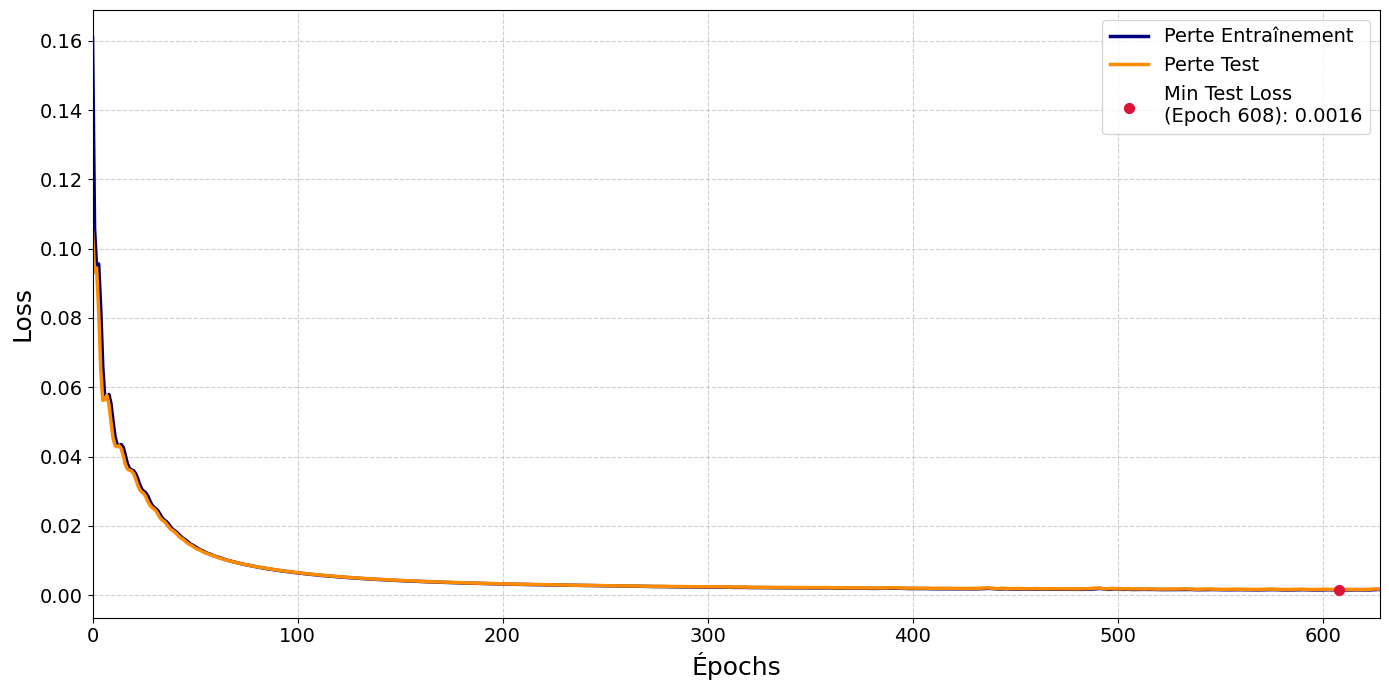

In [16]:
plot_losses(train_losses, test_losses, title="MLP Training")

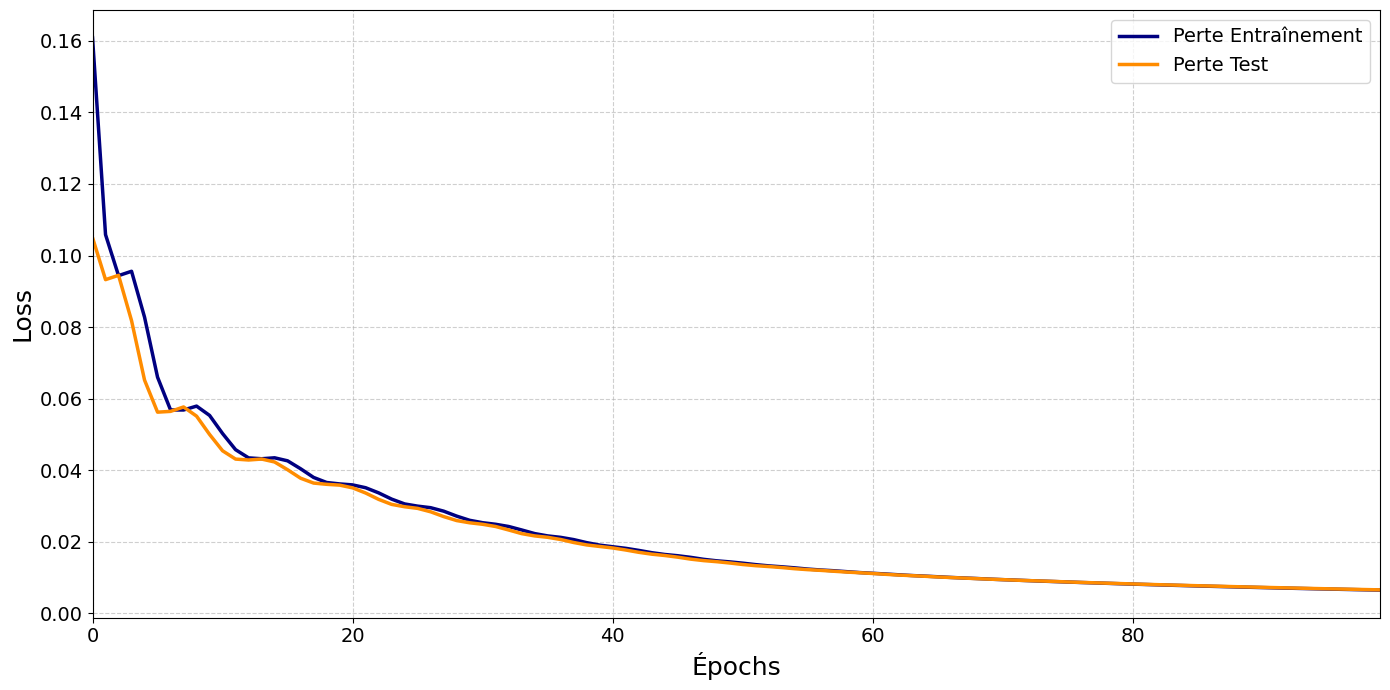

In [ ]:
import matplotlib.pyplot as plt

def plot_losses_subset(train_loss, test_loss, title, start_epoch=0, end_epoch=100):
    """
    Plot training and test loss curves over a specified epoch range.

    Args:
        train_loss (list or array): Training loss values.
        test_loss (list or array): Test loss values.
        title (str): Title of the plot.
        start_epoch (int): Starting epoch (inclusive).
        end_epoch (int): Ending epoch (exclusive).

    Returns:
        None
    """
    # Prepare figure and style
    plt.style.use('default')
    plt.figure(figsize=(14, 7))

    # Select subset of losses to plot
    train_loss_subset = train_loss[start_epoch:end_epoch]
    test_loss_subset = test_loss[start_epoch:end_epoch]
    epochs = range(start_epoch, start_epoch + len(train_loss_subset))

    # Plot training and test losses
    plt.plot(epochs, train_loss_subset, label='Training Loss', color='navy', linewidth=2.5)
    plt.plot(epochs, test_loss_subset, label='Test Loss', color='darkorange', linewidth=2.5)

    # Plot formatting
    plt.xlabel('Epochs', fontsize=18)
    plt.ylabel('Loss', fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlim(start_epoch, end_epoch - 1)
    plt.legend(fontsize=14, loc='best')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()

    # Show plot
    plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
import torch

def evaluate_model(model, X_test, y_test, scaler_y):
    """
    Evaluate a trained model on test data and compute performance metrics.

    Args:
        model (torch.nn.Module): Trained PyTorch model.
        X_test (torch.Tensor): Test features tensor.
        y_test (torch.Tensor): Test labels tensor (normalized).
        scaler_y (sklearn.preprocessing.MinMaxScaler): Scaler used to normalize y.

    Returns:
        y_test_orig (np.ndarray): Original scale test labels.
        y_pred_orig (np.ndarray): Original scale model predictions.
        metrics (dict): Dictionary with RMSE and R² for each output.
    """
    # Set model to evaluation mode and make predictions
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test)

    # Inverse transform the normalized labels and predictions
    y_test_orig = inverse_transform_y(y_test, scaler_y)
    y_pred_orig = inverse_transform_y(y_pred, scaler_y)

    # Compute metrics per output dimension
    n_outputs = y_test_orig.shape[1]
    metrics = {}
    for i in range(n_outputs):
        rmse = mean_squared_error(y_test_orig[:, i], y_pred_orig[:, i], squared=False)
        r2 = r2_score(y_test_orig[:, i], y_pred_orig[:, i])
        metrics[f"Output {i + 1}"] = {"RMSE": rmse, "R²": r2}

    # Print formatted metrics for common outputs
    print("Evaluation Metrics:")
    for i, (output_name, metric) in enumerate(metrics.items()):
        if i == 0:
            print(f"Thickness - RMSE: {metric['RMSE']:.4f}, R²: {metric['R²']:.4f}")
        elif i == 1:
            print(f"Volume Fraction - RMSE: {metric['RMSE']:.4f}, R²: {metric['R²']:.4f}")
        else:
            print(f"{output_name} - RMSE: {metric['RMSE']:.4f}, R²: {metric['R²']:.4f}")

    return y_test_orig, y_pred_orig, metrics


c:\Users\TimWi_x1vpvf2\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\TimWi_x1vpvf2\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Évaluation des métriques :
Épaisseur (thickness) - RMSE: 12.6847, R²: 0.9947
Fraction volumique (vfraction) - RMSE: 0.0165, R²: 0.9632


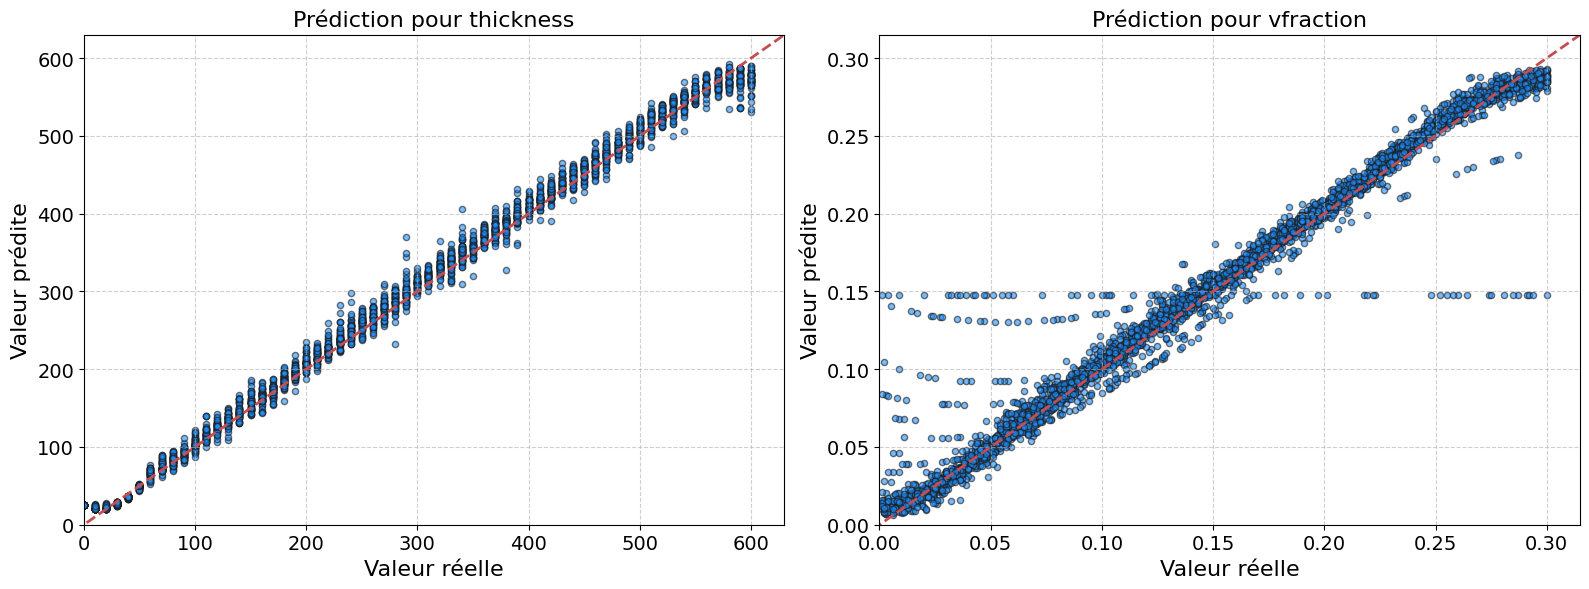

In [19]:
y_test_orig, y_pred_orig, metrics = evaluate_model(mlp_model, data['X_test'], data['y_test'], data['scaler_y'])
plot_predictions(mlp_model, data['X_test'], data['y_test'], data['scaler_y'], labels_std, title="MLP Predictions")